```{contents}
```
## BiRNN

**BiRNN (Bidirectional Recurrent Neural Network)** extends a standard RNN by processing the input sequence **in both directions — forward and backward** — to capture **past and future context** simultaneously.

---

### 1. **Intuition**

A normal RNN processes data **only from past → future**, i.e. left-to-right.
However, in many real-world problems, **the meaning of a word or event depends on what comes after it**, not just before.

**Example:**
In the sentence *“He sat on the bank of the river”*,
the word *“bank”* can only be correctly interpreted once you see *“river”*.

A **Bidirectional RNN** solves this by combining:

* a **forward RNN** → reads sequence from $x_1$ to $x_T$
* a **backward RNN** → reads sequence from $x_T$ to $x_1$

The outputs from both directions are merged (concatenated, summed, or averaged).

![alt text](../../images/birnn.png)


---

### 2. **Architecture**

Each time step ( t ) has:

* **Forward hidden state** ( \overrightarrow{h_t} )
* **Backward hidden state** ( \overleftarrow{h_t} )

These are combined into the overall output:

$$
h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]
$$

This allows the model to use information from both past and future inputs at each step.

---

### 3. **Mathematical Workflow**

Let input sequence be ( x_1, x_2, ..., x_T )

**Forward pass:**

$$
\overrightarrow{h_t} = f(W_{xh}^{→}x_t + W_{hh}^{→}\overrightarrow{h_{t-1}} + b^{→})
$$

**Backward pass:**
$$
\overleftarrow{h_t} = f(W_{xh}^{←}x_t + W_{hh}^{←}\overleftarrow{h_{t+1}} + b^{←})
$$

**Combined output:**

$$
y_t = g(W_y[\overrightarrow{h_t}, \overleftarrow{h_t}] + b_y)
$$

Where:

* ( f ) = activation function (e.g., tanh, ReLU)
* ( g ) = output function (e.g., softmax for classification)

---

### 4. **Workflow Summary**

| Step | Component             | Function                           | Direction               |
| ---- | --------------------- | ---------------------------------- | ----------------------- |
| 1    | Forward RNN           | Processes from start to end        | ( x_1 \rightarrow x_T ) |
| 2    | Backward RNN          | Processes from end to start        | ( x_T \rightarrow x_1 ) |
| 3    | Combine outputs       | Concatenate or merge hidden states | Both directions         |
| 4    | Generate final output | Feed to next layer or classifier   | Unified context         |

---

### 5. **Variants**

| Type       | Description                                             |
| ---------- | ------------------------------------------------------- |
| **BiRNN**  | Uses vanilla RNN cells in both directions               |
| **BiLSTM** | Uses LSTM cells (handles long-term dependencies better) |
| **BiGRU**  | Uses GRU cells (simpler, faster version)                |

---

### 6. **Advantages**

| Advantage                 | Explanation                                                      |
| ------------------------- | ---------------------------------------------------------------- |
| **Full context**          | Sees both past and future — useful for language and speech tasks |
| **Better accuracy**       | Outperforms unidirectional RNNs in many NLP tasks                |
| **Flexible architecture** | Works with any RNN variant (LSTM, GRU, etc.)                     |

---

### 7. **Disadvantages**

| Disadvantage                | Explanation                                                          |
| --------------------------- | -------------------------------------------------------------------- |
| **Higher computation cost** | Two RNNs instead of one                                              |
| **Not causal**              | Cannot be used for real-time prediction (future input not available) |
| **More parameters**         | Requires double memory and training time                             |

---

### 8. **Applications**

* NLP: POS tagging, NER, sentiment analysis
* Speech recognition
* Machine translation
* Handwriting recognition

---

### 9. **Intuitive Summary**

| Model              | Reads Direction       | Context Access                       |
| ------------------ | --------------------- | ------------------------------------ |
| **RNN**            | Forward only          | Past context only                    |
| **BiRNN**          | Forward + backward    | Past + future context                |
| **BiLSTM / BiGRU** | Same, but with gating | Long-range context, stable gradients |

---

### 10. **Example (Conceptual Diagram)**

```
Input:  x1 → x2 → x3 → x4

Forward pass:  → h1 → h2 → h3 → h4
Backward pass:  ← h1 ← h2 ← h3 ← h4

Combined output at each time step:
h_t = $$forward_h_t , backward_h_t$$
```



### Demonstration 
---

#### Cell 1 —#Install and Import Libraries

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt


#### Cell 2 — Generate Synthetic Time Series Data

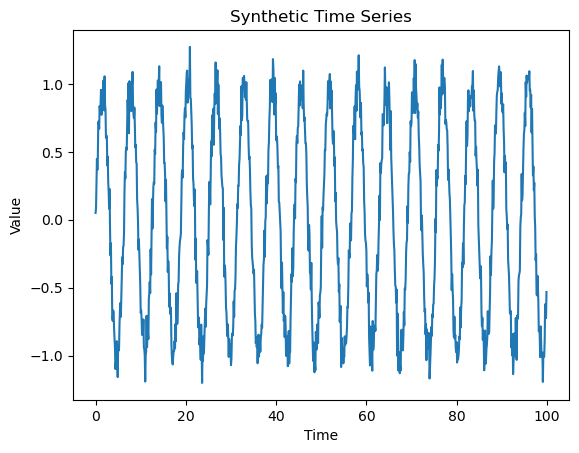

In [2]:
np.random.seed(42)
time = np.arange(0, 100, 0.1)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))

plt.plot(time, data)
plt.title("Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


#### 🧩 **Cell 3 — Prepare Data for BiRNN**

In [3]:
window_size = 20
X, y = [], []

for i in range(len(data) - window_size):
    X.append(data[i:i + window_size])
    y.append(data[i + window_size])

X = np.array(X).reshape(-1, window_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 784, Test samples: 196


#### 🧩 **Cell 4 — Define Hyperparameter Grid and Callbacks**

In [4]:
batch_sizes = [16, 32]
learning_rates = [0.001, 0.005]
dropouts = [0.1, 0.3]

# Learning rate schedule
def lr_scheduler(epoch, lr):
    return lr * 0.9 if epoch > 10 else lr

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


#### 🧩 **Cell 5 — Train and Evaluate Bidirectional LSTM Models**

In [5]:

results = []

for batch_size, lr, dropout_rate in itertools.product(batch_sizes, learning_rates, dropouts):
    model = Sequential([
        Bidirectional(LSTM(50, input_shape=(window_size, 1))),
        Dropout(dropout_rate),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=0,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
    )

    test_loss = model.evaluate(X_test, y_test, verbose=0)
    results.append((batch_size, lr, dropout_rate, test_loss))

results_df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Dropout", "Test Loss"])
results_df


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,Batch Size,Learning Rate,Dropout,Test Loss
0,16,0.001,0.1,0.010570
1,16,0.001,0.3,0.011009
2,16,0.005,0.1,0.010775
3,16,0.005,0.3,0.010745
4,32,0.001,0.1,0.010643
5,32,0.001,0.3,0.010540
6,32,0.005,0.1,0.010631
7,32,0.005,0.3,0.010758


---

### 🧩 **Cell 6 — Select Best Configuration**

In [6]:
best_config = results_df.loc[results_df["Test Loss"].idxmin()]
print("Best Configuration:")
print(best_config)


Best Configuration:
Batch Size       32.00000
Learning Rate     0.00100
Dropout           0.30000
Test Loss         0.01054
Name: 5, dtype: float64




---

### 🧩 **Cell 7 — Retrain Best Bidirectional LSTM and Visualize Predictions**



Epoch 1/50


C:\Users\sangouda\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3354 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0586 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0250 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0191 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0189 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0184 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - val_loss: 0.0116 - learning_rate: 0.0010
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49

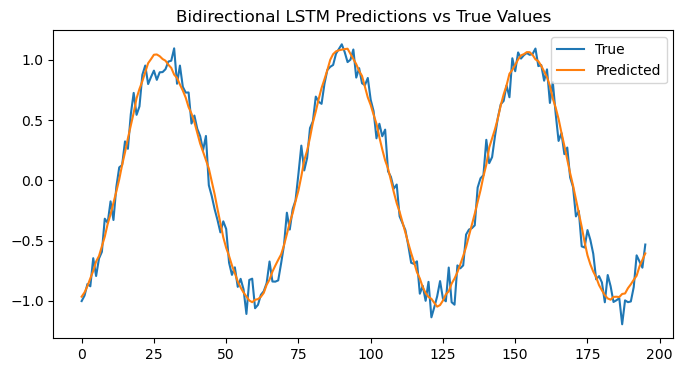

In [7]:

best_batch = int(best_config["Batch Size"])
best_lr = float(best_config["Learning Rate"])
best_dropout = float(best_config["Dropout"])

best_model = Sequential([
    Bidirectional(LSTM(50, input_shape=(window_size, 1))),
    Dropout(best_dropout),
    Dense(1)
])
best_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))

history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=best_batch,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop, LearningRateScheduler(lr_scheduler)]
)

preds = best_model.predict(X_test)

plt.figure(figsize=(8,4))
plt.plot(y_test, label="True")
plt.plot(preds, label="Predicted")
plt.title("Bidirectional LSTM Predictions vs True Values")
plt.legend()
plt.show()



---

#### **Explanation of Workflow**

| Step | Operation                          | Purpose                                   |
| ---- | ---------------------------------- | ----------------------------------------- |
| 1    | Generate synthetic sine wave       | Simulated time-series input               |
| 2    | Prepare sliding windows            | Create sequential training data           |
| 3    | Build BiLSTM model                 | Capture both past and future dependencies |
| 4    | Apply early stopping + LR schedule | Improve training stability                |
| 5    | Tune hyperparameters               | Optimize model performance                |
| 6    | Retrain best model                 | Produce final predictive model            |

---

#### **Key Insights**

| Aspect     | Unidirectional LSTM      | Bidirectional LSTM                                   |
| ---------- | ------------------------ | ---------------------------------------------------- |
| Context    | Past only                | Past + Future                                        |
| Parameters | Fewer                    | Double (two LSTMs)                                   |
| Speed      | Faster                   | Slower                                               |
| Accuracy   | Moderate                 | Higher (especially for text or contextual sequences) |
| Use Case   | Real-time, causal models | Offline tasks (NLP, speech, time-series analysis)    |